In [1]:
import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import tensorflow_hub as hub
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv("./train_digit.csv",sep=",")
test = pd.read_csv("./test_digit.csv",sep=",")

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
5402,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3870,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5025,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5442,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist_dataframe.iloc[:, 72:72]

""
5402
3870
9599
5025
5442
4648
6932
2632
4290
6679


In [4]:
def parse_labels_and_features(dataset):
  """Extracts labels and features.

  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset.label

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.iloc[:,1:785]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features / 255
  print(features)
  return labels, features


In [5]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])

      pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
5402     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3870     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9599     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5025     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5442     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4648     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6932     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2632     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4290     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6679     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
6098     0.0     0.0     0.0     0.0    

In [6]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])

      pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
6727     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
629      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7259     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
442      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3543     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5407     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1081     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1321     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2594     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7326     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
7606     0.0     0.0     0.0     0.0    

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


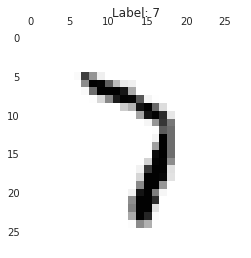

In [7]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

In [8]:
def adjust_image(data):
    # Reshaped to [batch, height, width, channels].
    imgs = tf.reshape(data, [-1, 28, 28, 1])
    # Adjust image size to that in Inception-v3 input.
    imgs = tf.image.resize_images(imgs, (96, 96))
    # Convert to RGB image.
    imgs = tf.image.grayscale_to_rgb(imgs)
    return imgs


def mobilenet_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/2")
    input_layer = adjust_image(features["pixels"])
    outputs = module(input_layer)

    logits = tf.layers.dense(inputs=outputs, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [9]:
def construct_feature_columns():
  # There are 784 pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [10]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [11]:
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [12]:
def train_hub_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10

    steps_per_period = steps / periods  

    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
  
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)
  
    training_input_fn = create_training_input_fn(training_examples, training_targets, batch_size)
  
    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
    
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)

    training_input_fn = create_training_input_fn(training_examples, training_targets, batch_size)
  
    feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
###############################################################
    classifier = tf.estimator.Estimator(
    model_fn=mobilenet_model_fn, model_dir="/tmp/transfer/1")
##############################################################################
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['classes'] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['classes'] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    

        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['classes'] for item in final_predictions])


    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 4.48
  period 01 : 4.31
  period 02 : 4.10
  period 03 : 4.12
  period 04 : 3.99
  period 05 : 3.97
  period 06 : 3.80
  period 07 : 3.74
  period 08 : 3.70
  period 09 : 3.63
Model training finished.
Final accuracy (on validation data): 0.89


/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


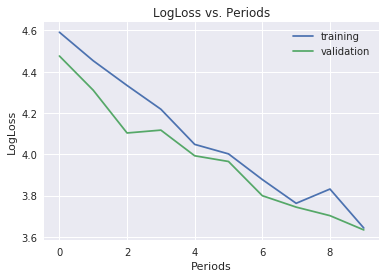

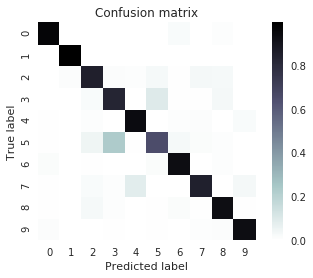

In [13]:
classifier = train_hub_classification_model(
    learning_rate=0.5,
    steps=1000,
    batch_size=30,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [14]:
test = test / 255
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def my_test_input_fn(features, batch_size=1, shuffle=True, num_epochs=None):
    raw_features = {"pixels": features.values}
    ds = Dataset.from_tensor_slices((raw_features))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(10000)
    features = ds.make_one_shot_iterator().get_next()
    return features

predict_test_input_fn = lambda: my_test_input_fn(
    test,
    num_epochs=1,
    shuffle=False)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['classes'] for item in test_predictions])

In [16]:
my_submission = pd.DataFrame({'ImageId': test.index + 1, 'Label': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('sub_digit_transfer.csv', index=False)